# <div style="width: 100%"><h1 style="text-align: center; font-family: 'Roboto', sans-serif; color: rgb(236, 199, 110); background-color: rgba(55, 109, 248, 0.6); padding: 30px; border: 5px solid rgb(18, 199, 229); border-style: solid; border-radius: 10px;"> Imports & Load Data </h1></div>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
base_path = "/kaggle/input/google-stock-data/GOOGL.csv"
df = pd.read_csv(base_path)
TARGET = 'Close'

import warnings
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2
%matplotlib inline

sns.set()
sns.set_palette('rainbow')
SNS_CMAP = 'rainbow'
plt.style.use("dark_background")
plt.rcParams['grid.color'] = '#444444'
colors = sns.palettes.color_palette(SNS_CMAP)
pd.options.mode.chained_assignment = None

In [2]:
df.head().style.background_gradient(cmap=SNS_CMAP)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-08-19,50.050049,52.082081,48.028027,50.220219,50.220219,44659096
1,2004-08-20,50.555557,54.594597,50.300301,54.209209,54.209209,22834343
2,2004-08-23,55.430431,56.796799,54.579578,54.754753,54.754753,18256126
3,2004-08-24,55.675674,55.855858,51.836838,52.487488,52.487488,15247337
4,2004-08-25,52.532532,54.054054,51.991993,53.053055,53.053055,9188602


In [3]:
df.describe().iloc[1:].style.background_gradient(cmap=SNS_CMAP)

,Open,High,Low,Close,Adj Close,Volume
mean,693.087345,699.735595,686.078751,693.097367,693.097367,6444992.357030
std,645.118799,651.331215,638.579488,645.187806,645.187806,7690350.582390
min,49.644646,50.920921,48.028027,50.055054,50.055054,465600.000000
25%,248.558563,250.853355,245.813309,248.415916,248.415916,1695600.000000
50%,434.924927,437.887878,432.687683,435.330322,435.330322,3778418.000000
75%,1007.364990,1020.649994,997.274994,1007.790008,1007.790008,8002389.500000
max,3025.000000,3030.929932,2977.979980,2996.770020,2996.770020,82151167.000000


In [4]:
agg_df = df.agg(["nunique", "unique", lambda x:x.isna().sum(), "dtypes"]).T
agg_df['unique'] = agg_df['unique'].apply(lambda x: x if len(x)<10 else x[:10])
agg_df.style.apply(lambda s: [f'background-color: rgba({colors[0][0]*255}, {colors[0][1]*255}, {colors[0][2]*255}, 0.5)' if i % 2 == 0 else f'background-color: rgba({colors[5][0]*255}, {colors[5][1]*255}, {colors[5][2]*255}, 0.5)' for i in range(len(s))])

,nunique,unique,,dtypes
Date,4431,['2004-08-19' '2004-08-20' '2004-08-23' '2004-08-24' '2004-08-25' '2004-08-26' '2004-08-27' '2004-08-30' '2004-08-31' '2004-09-01'],0,object
Open,4314,[50.050049 50.555557 55.430431 55.675674 52.532532 52.527527 54.104103 52.692692 51.201202 51.401402],0,float64
High,4282,[52.082081 54.594597 56.796799 55.855858 54.054054 54.02903 54.364365 52.797798 51.906906 51.536537],0,float64
Low,4323,[48.028027 50.300301 54.579578 51.836838 51.991993 52.382381 52.8979 51.056057 51.13113 49.884884],0,float64
Close,4352,[50.220219 54.209209 54.754753 52.487488 53.053055 54.00901 53.128128 51.056057 51.236237 50.175175],0,float64
Adj Close,4352,[50.220219 54.209209 54.754753 52.487488 53.053055 54.00901 53.128128 51.056057 51.236237 50.175175],0,float64
Volume,4317,[44659096 22834343 18256126 15247337 9188602 7094898 6211782 5196798 4917877 9138253],0,int64


# <div style="width: 100%"><h1 style="text-align: center; font-family: 'Roboto', sans-serif; color: rgb(236, 199, 110); background-color: rgba(55, 109, 248, 0.6); padding: 30px; border: 5px solid rgb(18, 199, 229); border-style: solid; border-radius: 10px;"> EDA </h1></div>

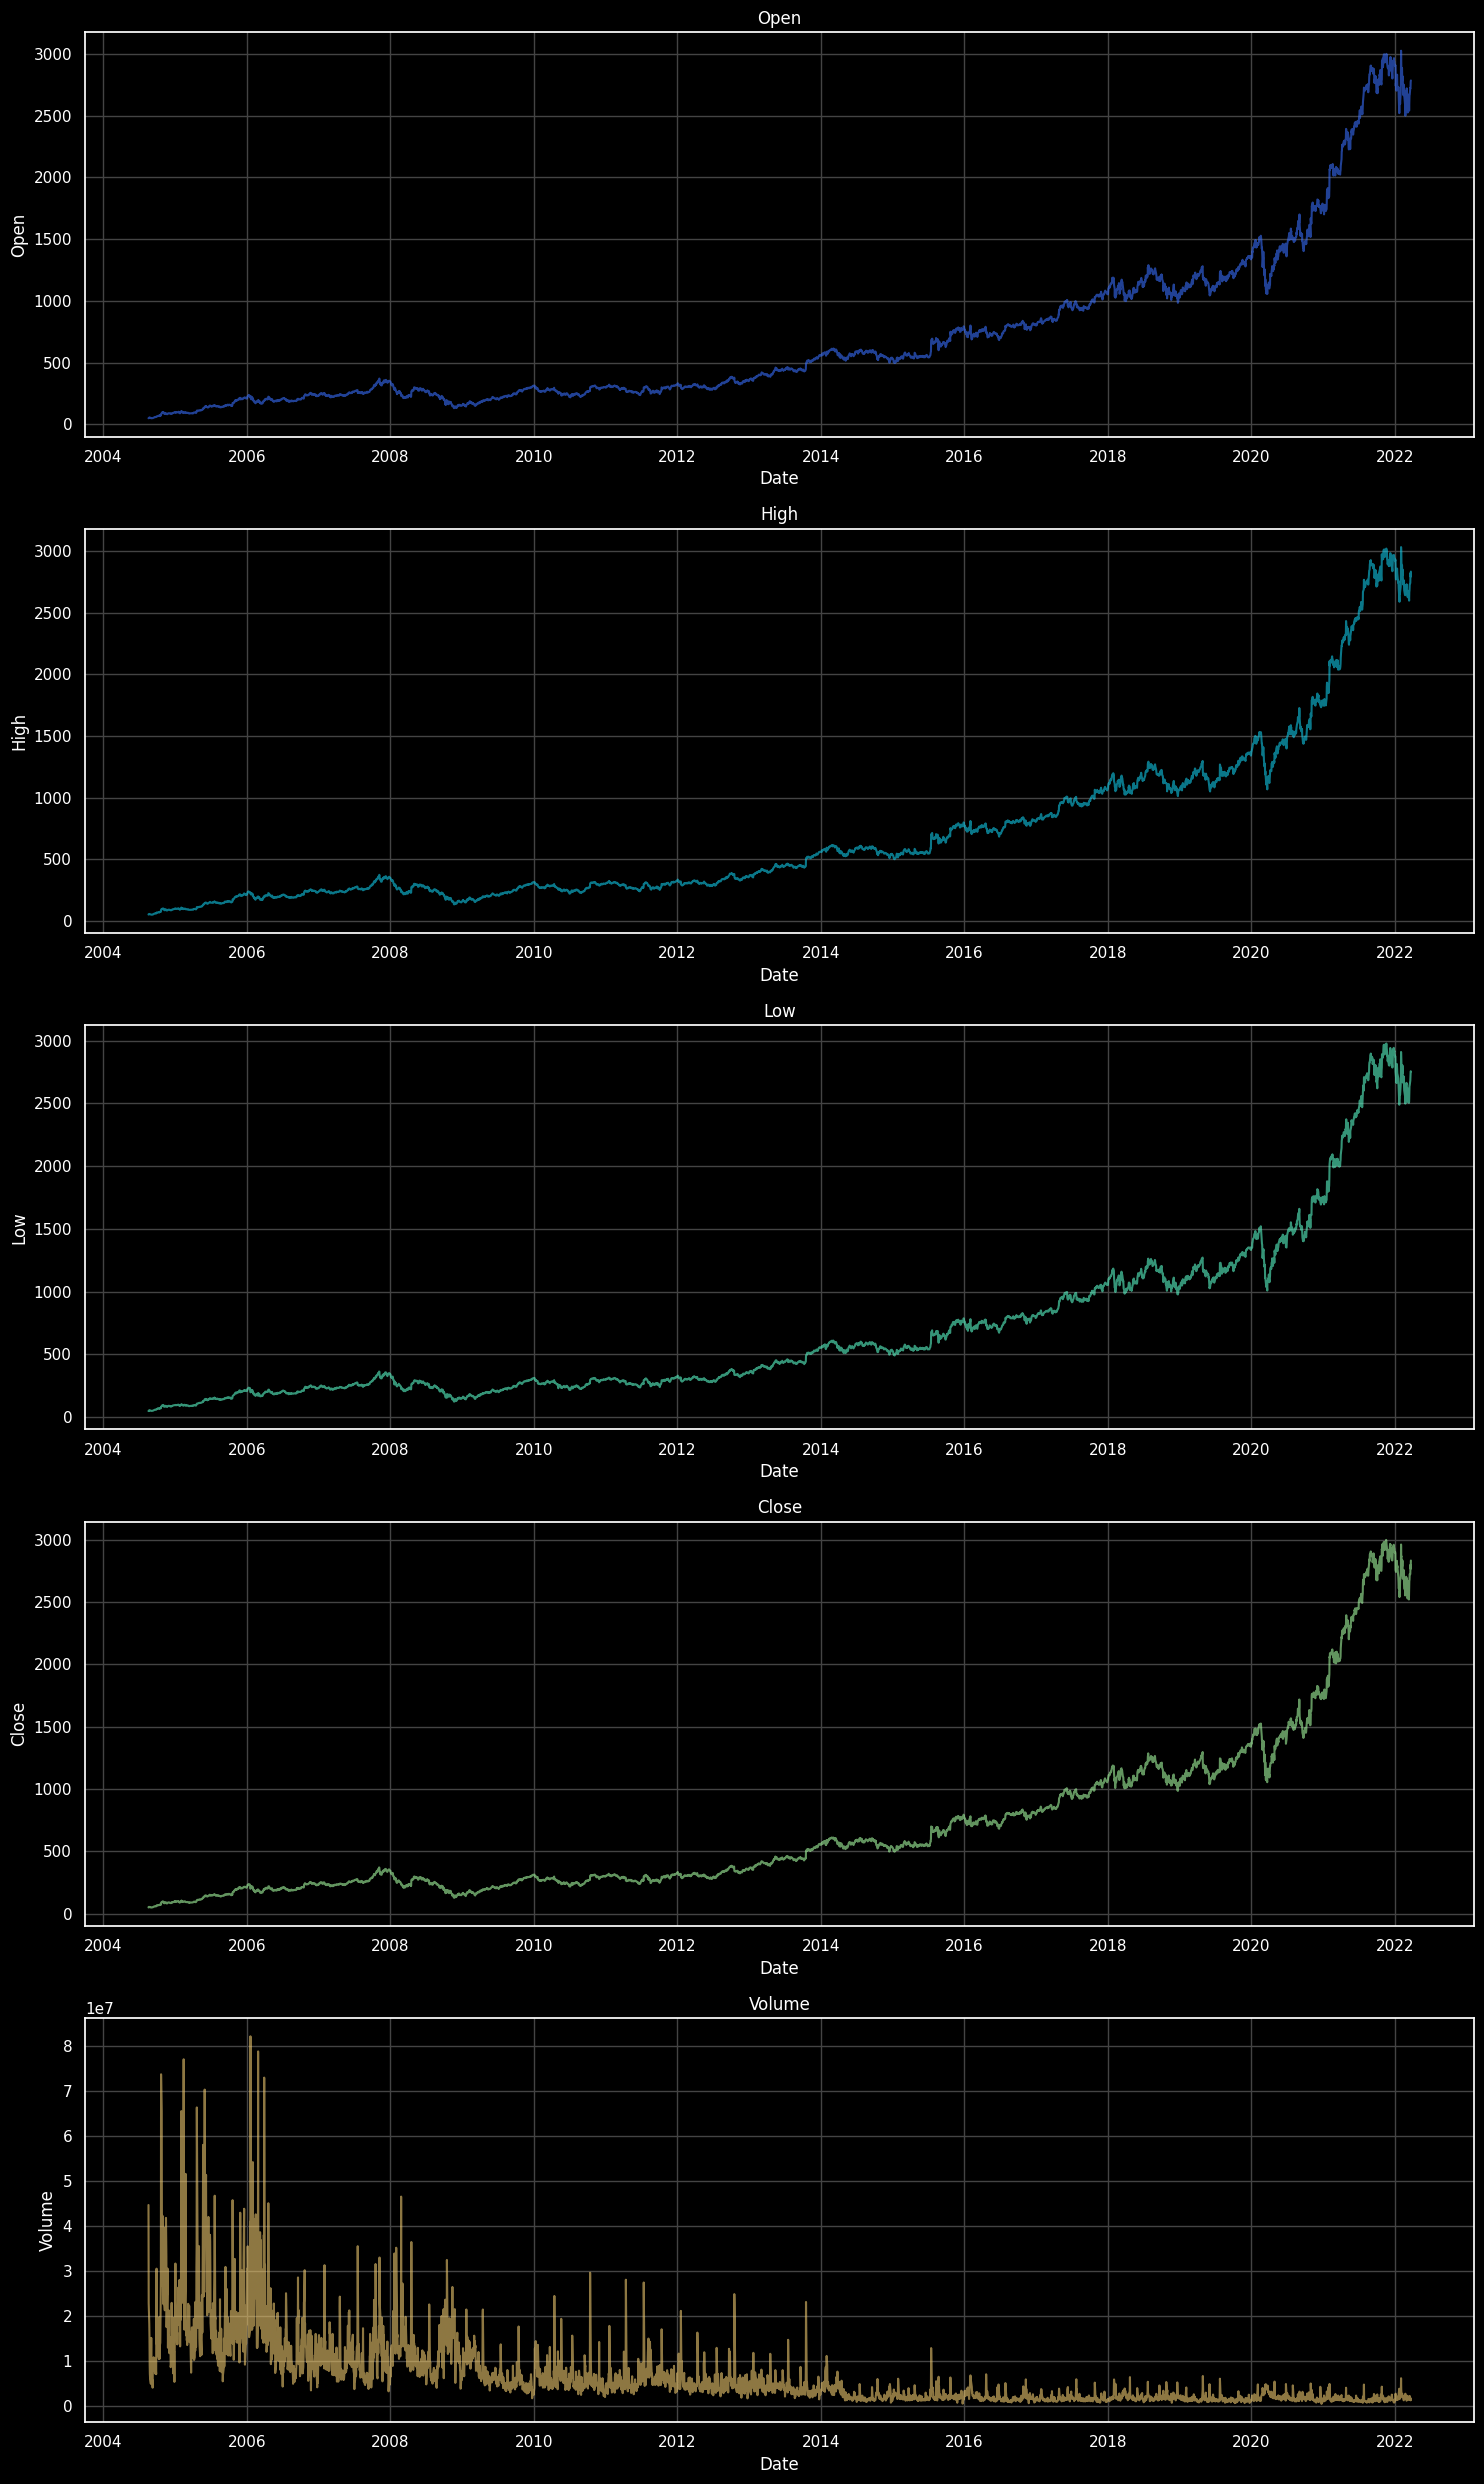

In [5]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d', errors='coerce')
cols = ['Open', 'High', 'Low', 'Close', 'Volume']
fig, ax = plt.subplots(len(cols), 1, figsize=(15, 5*len(cols)))
for i, col in enumerate(cols):
    ax[i].plot(df['Date'], df[col], label=col, alpha=0.6, color=colors[i])
    ax[i].set_title(col)
    ax[i].set_xlabel('Date')
    ax[i].set_ylabel(col)

plt.tight_layout()
plt.show()

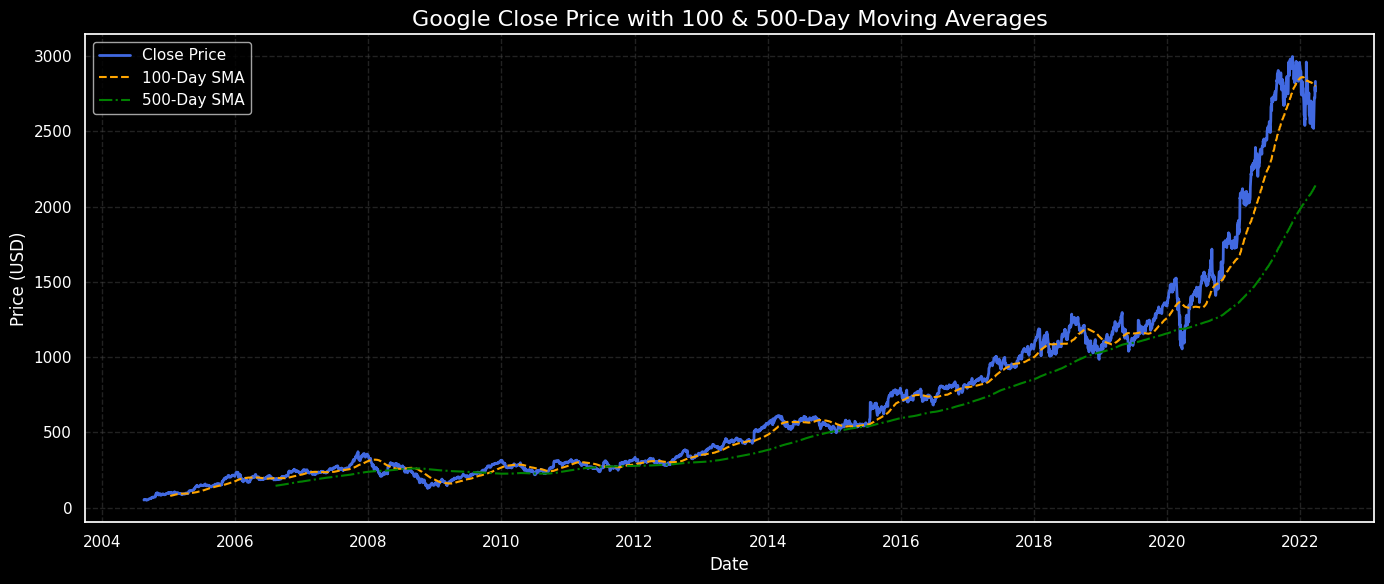

In [7]:
df['SMA_100'] = df['Close'].rolling(window=100).mean()
df['SMA_500'] = df['Close'].rolling(window=500).mean()
plt.figure(figsize=(14, 6))
plt.plot(df['Date'], df['Close'], label='Close Price', color='royalblue', linewidth=2)
plt.plot(df['Date'], df['SMA_100'], label='100-Day SMA', color='orange', linestyle='--')
plt.plot(df['Date'], df['SMA_500'], label='500-Day SMA', color='green', linestyle='-.')

plt.title('Google Close Price with 100 & 500-Day Moving Averages', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

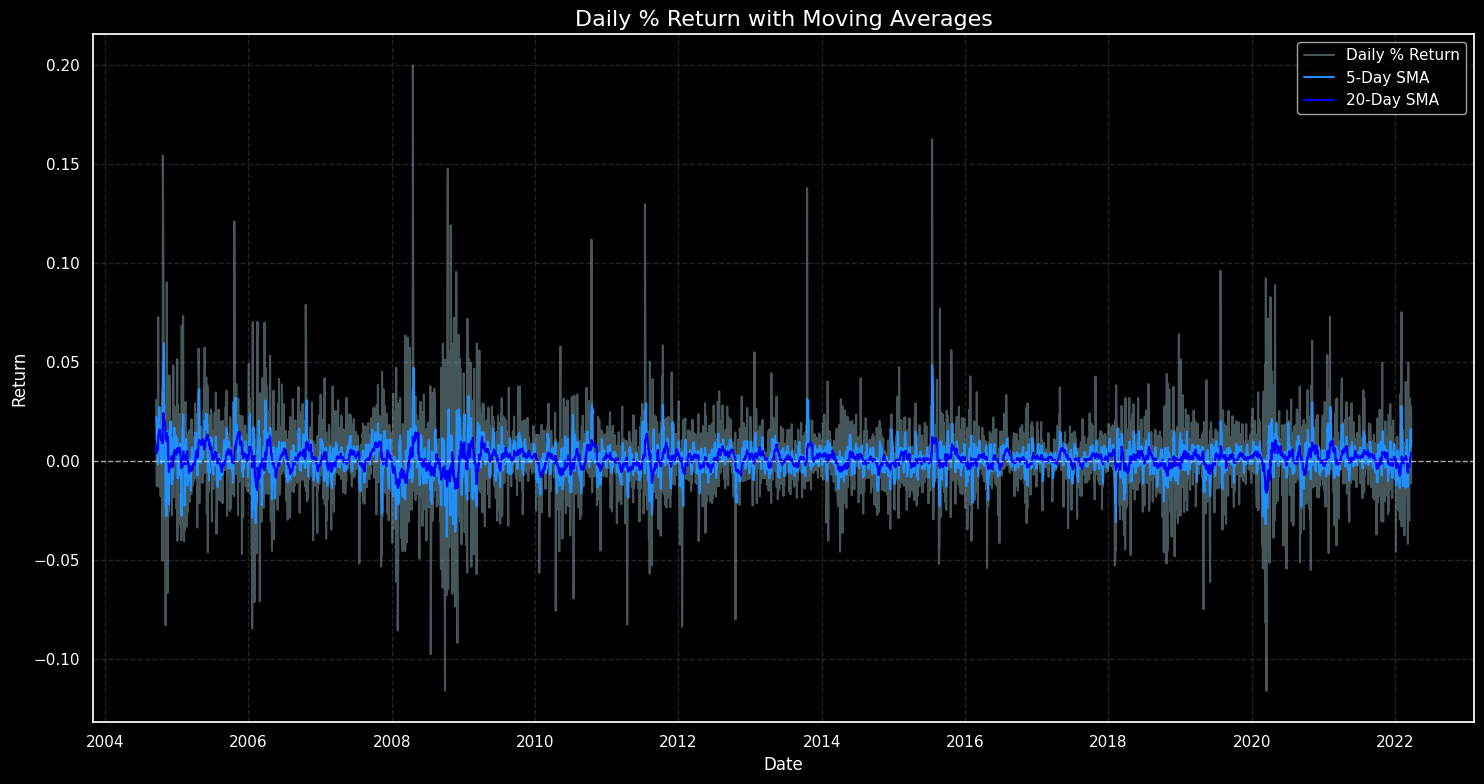

In [9]:
df['Return_pct'] = df['Close'].pct_change()

# Smooth using moving averages
df['Return_SMA_5'] = df['Return_pct'].rolling(window=5).mean()
df['Return_SMA_20'] = df['Return_pct'].rolling(window=20).mean()

# Drop NaNs
plot_df = df[['Date', 'Return_pct', 'Return_SMA_5', 'Return_SMA_20']].dropna()

# Plot
plt.figure(figsize=(15, 8))
plt.plot(plot_df['Date'], plot_df['Return_pct'], label='Daily % Return', alpha=0.4, color='lightblue')
plt.plot(plot_df['Date'], plot_df['Return_SMA_5'], label='5-Day SMA', color='dodgerblue')
plt.plot(plot_df['Date'], plot_df['Return_SMA_20'], label='20-Day SMA', color='blue')

plt.axhline(0, linestyle='--', color='white', linewidth=1, alpha=0.6)
plt.title('Daily % Return with Moving Averages', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Return')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

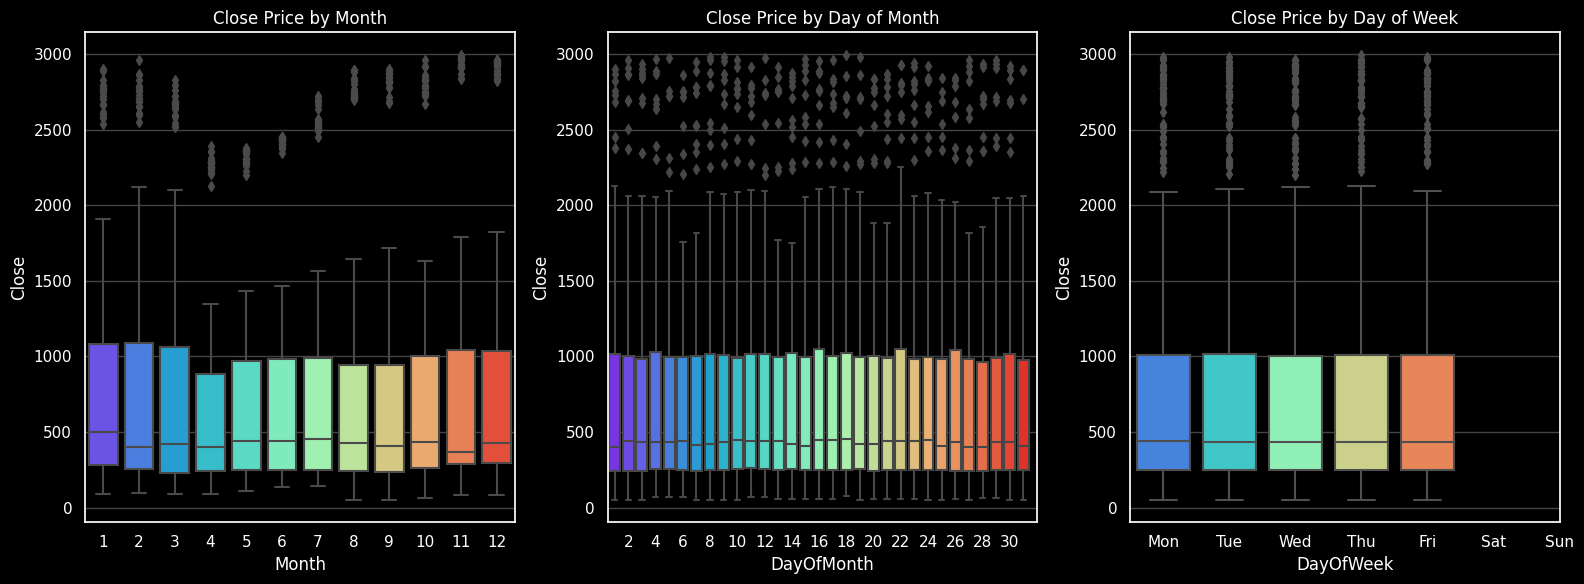

In [11]:
df['Month'] = df['Date'].dt.month
df['DayOfMonth'] = df['Date'].dt.day
df['DayOfWeek'] = df['Date'].dt.dayofweek

plt.figure(figsize=(16, 6))
plt.subplot(1, 3, 1)
sns.boxplot(x='Month', y='Close', data=df, palette=SNS_CMAP)
plt.title('Close Price by Month')

plt.subplot(1, 3, 2)
sns.boxplot(x='DayOfMonth', y='Close', data=df, palette=SNS_CMAP)
plt.xticks(ticks=range(1, 32, 2))
plt.title('Close Price by Day of Month')

plt.subplot(1, 3, 3)
sns.boxplot(x='DayOfWeek', y='Close', data=df, palette=SNS_CMAP)
plt.title('Close Price by Day of Week')
plt.xticks(ticks=range(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

plt.tight_layout()
plt.show()

# <div style="width: 100%"><h1 style="text-align: center; font-family: 'Roboto', sans-serif; color: rgb(236, 199, 110); background-color: rgba(55, 109, 248, 0.6); padding: 30px; border: 5px solid rgb(18, 199, 229); border-style: solid; border-radius: 10px;"> Auto-Regressive Prediction on `Close` </h1></div>

In [2]:
def generate_forwards(df:pd.DataFrame,
                      target:str,
                      seq_length: int = 60)->pd.DataFrame:
    df_seq = df[[target]]
    seqs = [df_seq.shift(i) for i in range(seq_length+1)]
    res = pd.concat(seqs, axis=1).dropna()
    col_names = [f'x{i}' for i in range(seq_length)] + ['y']
    res.columns = col_names
    return res

df = generate_forwards(df, 'Close', seq_length=60)
df.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x51,x52,x53,x54,x55,x56,x57,x58,x59,y
60,91.091087,91.601601,84.014015,84.434433,86.361359,84.759758,92.442444,95.930931,97.532532,98.113113,...,50.175175,51.236237,51.056057,53.128128,54.009010,53.053055,52.487488,54.754753,54.209209,50.220219
61,92.527527,91.091087,91.601601,84.014015,84.434433,86.361359,84.759758,92.442444,95.930931,97.532532,...,50.805805,50.175175,51.236237,51.056057,53.128128,54.009010,53.053055,52.487488,54.754753,54.209209
62,86.356354,92.527527,91.091087,91.601601,84.014015,84.434433,86.361359,84.759758,92.442444,95.930931,...,50.055054,50.805805,50.175175,51.236237,51.056057,53.128128,54.009010,53.053055,52.487488,54.754753
63,86.336334,86.356354,92.527527,91.091087,91.601601,84.014015,84.434433,86.361359,84.759758,92.442444,...,50.840839,50.055054,50.805805,50.175175,51.236237,51.056057,53.128128,54.009010,53.053055,52.487488
64,83.853851,86.336334,86.356354,92.527527,91.091087,91.601601,84.014015,84.434433,86.361359,84.759758,...,51.201202,50.840839,50.055054,50.805805,50.175175,51.236237,51.056057,53.128128,54.009010,53.053055


In [6]:
from sklearn.preprocessing import MinMaxScaler

X, y = df.drop(['y'], axis=1).values, df['y'].values
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

### <div style="text-align: center; font-family: 'Roboto', sans-serif; color: rgba(55, 109, 248, 1.0); background-color: rgba(164, 248, 158, 0.3); padding: 10px; border-style: solid; border-radius: 10px;"> Training RNN </div>

In [9]:
import torch
import torch.nn as nn

In [38]:
class SimpleRNN(nn.Module):
    def __init__(self, input_size=60, hidden_size=64, num_layers=2):
        super(SimpleRNN, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

In [39]:
model = SimpleRNN(input_size=60)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

X_train_tensor = torch.unsqueeze(torch.tensor(X_train, dtype=torch.float32), 0)
y_train_tensor = torch.unsqueeze(torch.tensor(y_train, dtype=torch.float32), 0)
X_test_tensor = torch.unsqueeze(torch.tensor(X_test, dtype=torch.float32), 0)
y_test_tensor = torch.unsqueeze(torch.tensor(y_test, dtype=torch.float32), 0)

EPOCHS = 200
history = {
    "train": [],
    "val": []
}
for epoch in range(EPOCHS):
    model.train()
    output = model(X_train_tensor)
    loss = loss_fn(output, y_train_tensor)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        val_output = model(X_test_tensor)
        val_loss = loss_fn(val_output, y_test_tensor)

    history["train"].append(loss.item()/y_train_tensor.shape[1])
    history["val"].append(val_loss.item()/y_test_tensor.shape[1])
    if epoch%10 == 0:
        print(f"Epoch {epoch+1:3d}/{EPOCHS}, Train Loss: {history['train'][-1]:.4f}, Val Loss: {history['val'][-1]:.4f}")


Epoch   1/200, Train Loss: 72.4335, Val Loss: 3451.0946
Epoch  11/200, Train Loss: 71.0043, Val Loss: 3429.3926
Epoch  21/200, Train Loss: 70.1802, Val Loss: 3416.7289
Epoch  31/200, Train Loss: 69.3851, Val Loss: 3404.1734
Epoch  41/200, Train Loss: 68.5904, Val Loss: 3391.5711
Epoch  51/200, Train Loss: 67.8119, Val Loss: 3379.1874
Epoch  61/200, Train Loss: 67.0519, Val Loss: 3367.0031
Epoch  71/200, Train Loss: 66.3078, Val Loss: 3354.9986
Epoch  81/200, Train Loss: 65.5781, Val Loss: 3343.1503
Epoch  91/200, Train Loss: 64.8613, Val Loss: 3331.4397
Epoch 101/200, Train Loss: 64.1565, Val Loss: 3319.8517
Epoch 111/200, Train Loss: 63.4628, Val Loss: 3308.3743
Epoch 121/200, Train Loss: 62.7796, Val Loss: 3296.9997
Epoch 131/200, Train Loss: 62.1064, Val Loss: 3285.7211
Epoch 141/200, Train Loss: 61.4427, Val Loss: 3274.5334
Epoch 151/200, Train Loss: 60.7884, Val Loss: 3263.4317
Epoch 161/200, Train Loss: 60.1431, Val Loss: 3252.4149
Epoch 171/200, Train Loss: 59.5066, Val Loss: 32